<a href="https://colab.research.google.com/github/ydecoster/Deep_Learning_ENSAE_2022/blob/main/notebook_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
<h1><center><strong><font color="chillipepper">Deep Learning - ENSAE 2022</font></strong></center></h1>
<h2><center><strong><font color="chillipepper">Score-based generative modeling through stochastic differential
equations</font></strong></center></h2>

---

Yann DE COSTER (yann.decoster@ensae.fr) et Rémi VIDAL (remi.vidal@ensae.fr)

Au travers de ce notebook nous mettons en application les méthodes de score-based generative modeling développée dans [ce papier](https://arxiv.org/pdf/2011.13456.pdf). Nous appliquons ce type de modèles pour générer de nouveaux échatillons d'images, à la manière des GANs. Les datasets utilisés seront toutefois différents de ceux utilisés dans l'article. Enfin, nous quantifierons nos résultats avec des scores appropriés.

# I) Imports et installations

### Packages

In [ ]:
!pip install natsort torchvision

In [ ]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2022-05-02 09:38:40--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-05-02 09:38:41 (34.4 MB/s) - ‘helper.py’ saved [2813/2813]



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import functools
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm

import os
import natsort
from PIL import *
import PIL.Image
import helper
import matplotlib.pyplot as plt

from scipy import integrate

### Données

Après avoir testé les modèles sur la base Fashion MNIST, nous pensions qu'il serait plus intéressant de les tester sur une base plus éloignée que MNIST, qui est utilisée dans le notebook des auteurs. Nous avons donc choisi la base de données [Cars](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), qui recense plus de 16 000 images de voitures.

In [ ]:
! wget -c http://ai.stanford.edu/~jkrause/car196/cars_train.tgz

--2022-05-02 09:39:25--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  17.6MB/s    in 56s     

2022-05-02 09:40:22 (16.6 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
# Extraction
import tarfile
tar = tarfile.open('cars_train.tgz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


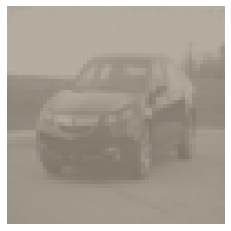

In [ ]:
# Mise en forme des données

data_dir = 'cars_train'
batch_size =  32 #@param {'type':'integer'}

transform = transforms.Compose([transforms.Resize([60, 60]),
                                transforms.Grayscale(1),
                                transforms.ToTensor()])
dataset = CustomDataSet(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

image = next(iter(dataloader))
helper.imshow(image[0,:])
plt.show()

# II) Définition du score-based model

Nous reprenons ici le code des auteurs, dont les notebooks sont disponibles [ici](https://yang-song.github.io/blog/2021/score/). La première étape consiste à construire le réseau de neurones nous permettant d'estimer la fonction de score $\nabla_x \log p_t(x)$.

In [ ]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[64, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

# III) Entraînement du modèle

### Définition de l'équation différentielle stochastique

On spécifie ici la SDE utilisée pour bruiter la distribution $p_0$ en un prior $p_T$. Nous reprenons celle proposée dans le notebook des auteurs : 

$$d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]$$

Etant donné cette SDE, la première fonction renvoie l'écart type de la distribution marginale, soit $\frac{1}{2\log \sigma}(\sigma^{2t} - 1)$, tandis que la deuxième calcule le coefficient de diffusion $\sigma^t$.

In [ ]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Définition de la fonction de perte du modèle

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Boucle d'entraînement

In [ ]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   300#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

# optimizer = Adam(score_model.parameters(), lr=lr)
# tqdm_epoch = tqdm.notebook.trange(n_epochs)
# for epoch in tqdm_epoch:
#   avg_loss = 0.
#   num_items = 0
#   for x in dataloader:
#     x = x.to(device)    
#     loss = loss_fn(score_model, x, marginal_prob_std_fn)
#     optimizer.zero_grad()
#     loss.backward()    
#     optimizer.step()
#     avg_loss += loss.item() * x.shape[0]
#     num_items += x.shape[0]
#   # Print the averaged training loss so far.
#   tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#   # Update the checkpoint after each epoch of training.
#   torch.save(score_model.state_dict(), 'ckpt.pth')

In [ ]:
# Checkpoint de Fashion_MNIST : 
# !wget "https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_fashion.pth"

# Checkpoint de Cars : 
!wget "https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_cars_600ep_60px.pth"

--2022-05-01 22:45:42--  https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_cars_600ep_60px.pth
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ydecoster/Deep_Learning_ENSAE_2022/main/ckpt_cars_600ep_60px.pth [following]
--2022-05-01 22:45:43--  https://raw.githubusercontent.com/ydecoster/Deep_Learning_ENSAE_2022/main/ckpt_cars_600ep_60px.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4765613 (4.5M) [application/octet-stream]
Saving to: ‘ckpt_cars_600ep_60px.pth.1’

ckpt_cars_600ep_60p 100%[===================>]   4.54M  --.-KB/s    in 0.09s   

2022-05-01 22:45:44 (52.7 MB

In [ ]:
score_model.load_state_dict(torch.load("ckpt_cars_600ep_60px.pth"))

<All keys matched successfully>

# IV) Sampling

Une fois le modèle entraîné, on dispose d'une approximation de la fonction de score. On peut alors l'injecter dans l'équation différentielle stochastique inverse. Dans notre cas, la SDE inverse s'écrit :

$$d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}$$

On peut enfin résoudre cette équation via difféntes méthodes, comme la méthode classique d'Euler Maruyama. Un fine-tuning des trajectoires par une méthode de prédiction-correction permettant d'avoir de meilleurs échantillons est également développé par les auteurs. Enfin, on peut utiliser la probability flow ODE, dont la résolution backward permet d'échantillonner la même distibution que la SDE inverse. Dans notre cas, l'ODE s'écrit :

$$d\mathbf{x} =  -\frac{1}{2}\sigma^{2t} s_\theta(\mathbf{x}, t) dt$$


On définit ces trois méthodes dans les cellules suivantes :

### Définition de la méthode d'Euler-Maruyama

In [ ]:
## The number of sampling steps.
num_steps =  100#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 60, 60, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

### Définition de la méthode de Prédiction-Correction

In [ ]:
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  100#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 60, 60, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

### Définition de l'échantillonnage par l'ODE

In [ ]:
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-2 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 60, 60, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

### Sampling - Génération d'images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of function evaluations: 74


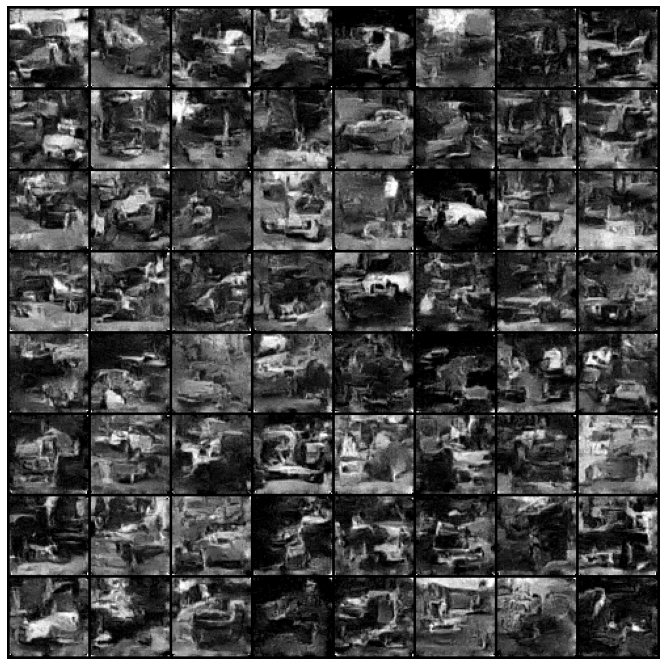

In [ ]:
from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

# ckpt = torch.load('ckpt_fashion.pth', map_location=device)
ckpt = torch.load('ckpt_cars_600ep_60px.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# V) Inception Score

We will use Inception score to evaluate our model as we are learning to generate something that was present in the classifier’s training data (ILSVRC 2014): cars.


In [ ]:
samples[0][0]

tensor([[ 0.1505,  0.2457,  0.0561,  ...,  0.5251,  0.5131, -0.2135],
        [ 0.2003,  0.1480,  0.0952,  ...,  0.5067,  0.5959, -0.0511],
        [ 0.1649,  0.1975,  0.2991,  ...,  0.4611,  0.4539,  0.3655],
        ...,
        [ 0.0789,  0.1754,  0.1378,  ...,  0.5391,  0.6101,  0.4217],
        [ 0.4086,  0.3040,  0.3195,  ...,  0.7225,  1.0000, -0.1808],
        [ 0.1285,  0.8530,  0.3644,  ...,  0.5972,  1.0000,  1.0000]],
       device='cuda:0', dtype=torch.float64)

In [ ]:
!wget "https://raw.githubusercontent.com/sbarratt/inception-score-pytorch/master/inception_score.py"

--2022-05-01 22:46:02--  https://raw.githubusercontent.com/sbarratt/inception-score-pytorch/master/inception_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2990 (2.9K) [text/plain]
Saving to: ‘inception_score.py.1’

inception_score.py. 100%[===================>]   2.92K  --.-KB/s    in 0s      

2022-05-01 22:46:03 (37.8 MB/s) - ‘inception_score.py.1’ saved [2990/2990]



In [ ]:
from inception_score import inception_score

### Score sur un ensemble de paramètres

In [ ]:
# Taking 1024 samples to evaluate our model, that we will split in 8 to see the variance
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  1024, 
                  device=device)

## Sample to clamp between to -1 and 1 for the Inception score to work best
samples = samples.clamp(-1.0, 1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of function evaluations: 44


In [ ]:
tensor_list = [samples[i].squeeze(0) for i in range(len(samples))]
stacked_tensor = torch.stack(tensor_list) #size [1024, 60, 60]

orig_shape = (1024, 60, 60)
new_shape = (1024, 3, 60, 60)
input = stacked_tensor
input = input.unsqueeze(1)
input = input.expand(*new_shape) #size [1024, 3, 60, 60]

inception_score(input, cuda=True, batch_size=32, resize=True, splits=8)

/content/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(2.0770589568859914, 0.09046118167741263)

### Fine-tuning (GridSearch)

In [ ]:
#Fixing epochs = 5 for time reasons
n_epochs = 5

#Grid search
batch_grid = [16, 32, 64]
lr_grid = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
sampler_grid = [Euler_Maruyama_sampler, pc_sampler, ode_sampler]
# Results for grid search
param = []
score = []

for batch_size in batch_grid:
    for lr in lr_grid:
        # training model
        optimizer = Adam(score_model.parameters(), lr=lr)
        tqdm_epoch = tqdm.notebook.trange(n_epochs)
        for epoch in tqdm_epoch:
          avg_loss = 0.
          num_items = 0
          for x in dataloader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
          # Print the averaged training loss so far.
          tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
          # Update the checkpoint after each epoch of training.
          torch.save(score_model.state_dict(), 'ckpt_' + str(batch_size) + 'batch_' + str(lr) + 'lr_' + str(n_epochs) + 'epc.pth')
        for sampler in sampler_grid:
            # Taking 1024 samples to evaluate our model, that we will split in 8 to see the variance
            samples = sampler(score_model, 
                              marginal_prob_std_fn,
                              diffusion_coeff_fn, 
                              1024, 
                              device=device)
            # Sample to clamp between to -1 and 1 for the Inception score to work best
            samples = samples.clamp(-1.0, 1.0)
            # Converting 1 chanel images to 3 chanels just by duplicating the chanel 3 times
            tensor_list = [samples[i].squeeze(0) for i in range(len(samples))]
            stacked_tensor = torch.stack(tensor_list) #size [1024, 60, 60]
            orig_shape = (1024, 60, 60)
            new_shape = (1024, 3, 60, 60)
            input = stacked_tensor
            input = input.unsqueeze(1)
            input = input.expand(*new_shape) #size [1024, 3, 60, 60]
            # Calculating the inception score
            iscore = inception_score(input, cuda=True, batch_size=32, resize=True, splits=8)
            print('IS for' + str(sampler) + ' and batch ' + str(batch_size) + ' and lr ' + str(lr) + ' epoch ' + str(n_epochs) + ':', iscore)
            # Adding info to lists
            score.append(iscore[0])
            param.append([sampler, batch_size, lr, n_epochs])

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-15-1775f9a58c13>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-15-1775f9a58c13>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 16 and lr 1e-05 epoch 5: (1.5979781738735936, 0.028579126816873912)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 16 and lr 1e-05 epoch 5: (1.5639400229105211, 0.04222173124820675)
Number of function evaluations: 62
IS for<function ode_sampler at 0x7fee72eb8790> and batch 16 and lr 1e-05 epoch 5: (1.9114862315248922, 0.08342194240996388)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 16 and lr 3e-05 epoch 5: (1.5902672349694496, 0.04552458716121081)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 16 and lr 3e-05 epoch 5: (1.6340423947642648, 0.04280917471112837)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 16 and lr 3e-05 epoch 5: (2.2436836293270956, 0.11677872494522408)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 16 and lr 0.0001 epoch 5: (1.649702966431519, 0.03734066603706824)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 16 and lr 0.0001 epoch 5: (1.6689953305033352, 0.06187383361468426)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 16 and lr 0.0001 epoch 5: (1.9932591917377696, 0.07818608634499931)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 16 and lr 0.0003 epoch 5: (1.5367098418993699, 0.04171328790584725)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 16 and lr 0.0003 epoch 5: (1.5839387999356211, 0.09002152463937935)
Number of function evaluations: 74
IS for<function ode_sampler at 0x7fee72eb8790> and batch 16 and lr 0.0003 epoch 5: (1.9990095587638548, 0.1188197208406332)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 16 and lr 0.001 epoch 5: (1.466837098130026, 0.024652214112772464)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 16 and lr 0.001 epoch 5: (1.4590334960620264, 0.03691432194855543)
Number of function evaluations: 56
IS for<function ode_sampler at 0x7fee72eb8790> and batch 16 and lr 0.001 epoch 5: (1.5928766079599246, 0.053747796631163594)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 32 and lr 1e-05 epoch 5: (1.5509445142338194, 0.038062230346162976)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 32 and lr 1e-05 epoch 5: (1.5321126966000826, 0.038764903891583345)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 32 and lr 1e-05 epoch 5: (2.080174418318922, 0.042145902775732554)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 32 and lr 3e-05 epoch 5: (1.5754800944112963, 0.04232585076069624)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 32 and lr 3e-05 epoch 5: (1.5621277059306273, 0.04361747832773882)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 32 and lr 3e-05 epoch 5: (2.1022109129562834, 0.08746065264455123)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 32 and lr 0.0001 epoch 5: (1.549656683937538, 0.03505092877061355)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 32 and lr 0.0001 epoch 5: (1.5526030938860174, 0.06247972250431458)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 32 and lr 0.0001 epoch 5: (2.187740346312042, 0.13698155416390057)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 32 and lr 0.0003 epoch 5: (1.4773171892228936, 0.026198179891527344)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 32 and lr 0.0003 epoch 5: (1.4458940255394888, 0.04155782898850934)
Number of function evaluations: 62
IS for<function ode_sampler at 0x7fee72eb8790> and batch 32 and lr 0.0003 epoch 5: (2.0093187538216726, 0.07800073518016244)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 32 and lr 0.001 epoch 5: (1.7413045512914416, 0.040513136825067825)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 32 and lr 0.001 epoch 5: (1.7974139417203463, 0.11717892230520881)
Number of function evaluations: 68
IS for<function ode_sampler at 0x7fee72eb8790> and batch 32 and lr 0.001 epoch 5: (1.9448153955298826, 0.04059051996771342)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 64 and lr 1e-05 epoch 5: (1.550291235857177, 0.05379009497970015)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 64 and lr 1e-05 epoch 5: (1.5093437642440977, 0.038145961898294424)
Number of function evaluations: 74
IS for<function ode_sampler at 0x7fee72eb8790> and batch 64 and lr 1e-05 epoch 5: (1.9345153459627644, 0.07279837290739342)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 64 and lr 3e-05 epoch 5: (1.5819310057477707, 0.04315917612706741)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 64 and lr 3e-05 epoch 5: (1.6058098894005661, 0.04244080152344762)
Number of function evaluations: 62
IS for<function ode_sampler at 0x7fee72eb8790> and batch 64 and lr 3e-05 epoch 5: (1.995824144047485, 0.07813811870043846)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 64 and lr 0.0001 epoch 5: (1.5318665814639219, 0.047783214123646896)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 64 and lr 0.0001 epoch 5: (1.55750135538741, 0.068472820255741)
Number of function evaluations: 44
IS for<function ode_sampler at 0x7fee72eb8790> and batch 64 and lr 0.0001 epoch 5: (2.2209884732359333, 0.09482467903119267)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 64 and lr 0.0003 epoch 5: (1.5867821978554724, 0.04279958009041901)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 64 and lr 0.0003 epoch 5: (1.632214365728573, 0.037272769122881515)
Number of function evaluations: 62
IS for<function ode_sampler at 0x7fee72eb8790> and batch 64 and lr 0.0003 epoch 5: (1.9873372770669828, 0.12678037558074257)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function Euler_Maruyama_sampler at 0x7fee6dd4fe50> and batch 64 and lr 0.001 epoch 5: (1.4127632242288795, 0.022855225483022216)


  0%|          | 0/100 [00:00<?, ?it/s]

IS for<function pc_sampler at 0x7fee7257dc10> and batch 64 and lr 0.001 epoch 5: (1.3722191323731503, 0.03507452834803717)
Number of function evaluations: 62
IS for<function ode_sampler at 0x7fee72eb8790> and batch 64 and lr 0.001 epoch 5: (2.0334673009499147, 0.08599619011402476)


In [ ]:
print('Best inception score:', max(score))
bp = param[score.index(max(score))]
print('obtained for: \nsampler', bp[0],
      '\nbatch size of', bp[1],
      '\nlearning rate of', bp[2],
      '\nnumber of epochs', bp[3])

Best inception score: 2.2436836293270956
obtained for: 
sampler <function ode_sampler at 0x7fee72eb8790> 
batch size of 16 
learning rate of 3e-05 
number of epochs 5
